# Predictive evaluation

## Statistical evaluation

In [9]:
import importlib
import post_analyzer
importlib.reload(post_analyzer)
from post_analyzer import PosteriorAnalyzer


theta_g_path_gamma = r'D:\Bachelor\theta_g_samples_train_optimal.parquet'
theta_l_path_gamma = r'D:\Bachelor\theta_l_samples_train_optimal.parquet'
gc_path_gamma = r'D:\Bachelor\Gc_samples_train_optimal.parquet'
sigma2_path_gamma = r'D:\Bachelor\sigma2_train_optimal.parquet'

theta_g_path_wishart = r'D:\Bachelor\theta_g_samples_optimal_wishart.parquet'
theta_l_path_wishart = r'D:\Bachelor\theta_l_samples_optimal_wishart.parquet'
gc_path_wishart = r'D:\Bachelor\Gc_samples_optimal_wishart.parquet'
sigma2_path_wishart = r'D:\Bachelor\sigma2_optimal_wishart.parquet'


post_analyzer_gamma = PosteriorAnalyzer(
    theta_g_path=theta_g_path_gamma,
    theta_l_path=theta_l_path_gamma,
    gc_path=gc_path_gamma,
    sigma2_path=sigma2_path_gamma,
    burn_in=0
)


post_analyzer_wishart = PosteriorAnalyzer(
    theta_g_path=theta_g_path_wishart,
    theta_l_path=theta_l_path_wishart,
    gc_path=gc_path_wishart,
    sigma2_path=sigma2_path_wishart,
    burn_in=0
)


In [5]:
import numpy as np
import pandas as pd
from data_loader import CountryDataLoader

file_path = r'D:\Bachelor Data\Train'

loader = CountryDataLoader(
    data_path=file_path,
    standardize=False,
    countries=None,  # or None for all
    mode="train"
)
features_to_drop = ["eom", "gvkey", "y", "weight","ret_exc_lead1m"]

loader.load_data(split_date="19940101")
train_data = loader.pretrain_dict
val_data = loader.train_dict 

# --- Train data ---
X_dict_train = {
    c: df.drop(columns=features_to_drop).to_numpy()
    for c, df in train_data.items()
}

Y_dict_train = {
    c: df["y"].to_numpy()
    for c, df in train_data.items()
}

X_train = np.vstack([X_dict_train[c] for c in X_dict_train])
Y_train = np.concatenate([Y_dict_train[c] for c in Y_dict_train])

features_to_drop = ["gvkey", "weight", "ret_exc_lead1m"]  

X_dict_val = {}
Y_dict_val = {}


In [6]:
## Import ridge 
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0, fit_intercept=False)
ridge.fit(X_train, Y_train)

del X_train 
del Y_train

In [7]:
global_coef = ridge.coef_

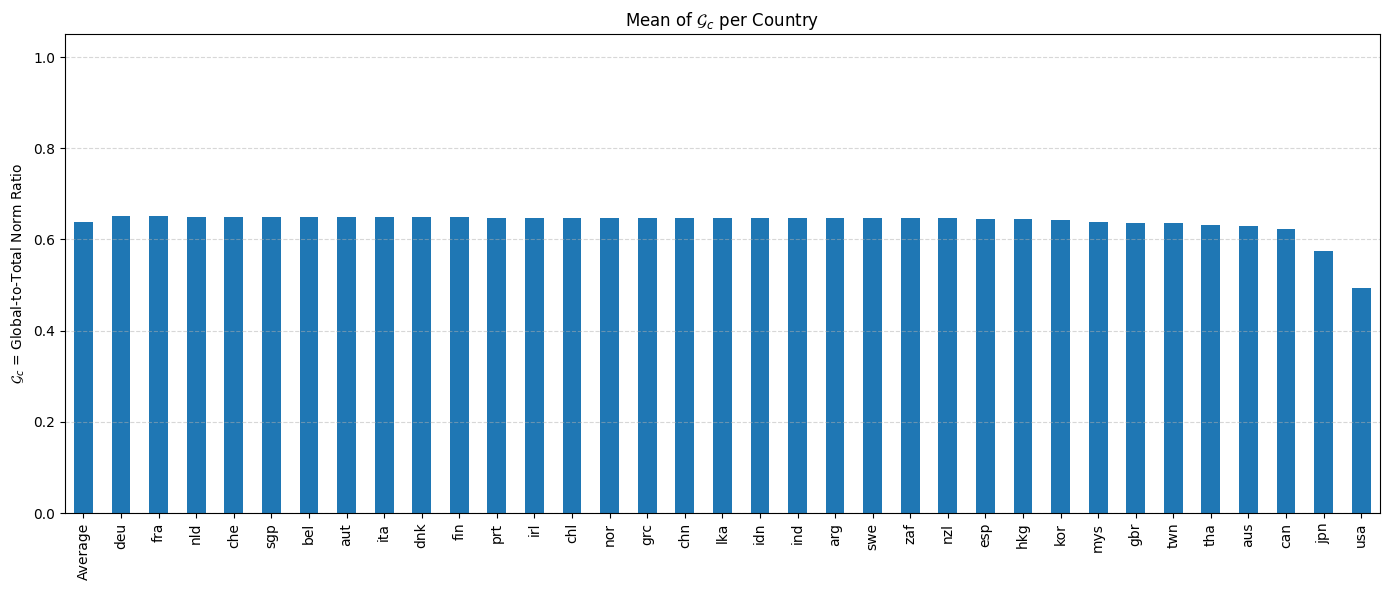

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Gc_mean = post_analyzer_gamma.get_Gc_posterior_mean()
Gc_mean["Average"] = np.mean([v for k, v in Gc_mean.items() if k != "Average"])

sorted_keys = ["Average"] + sorted([k for k in Gc_mean if k != "Average"], key=lambda x: Gc_mean[x], reverse=True)
Gc_mean_ordered = pd.Series({k: Gc_mean[k] for k in sorted_keys})

Gc_mean_ordered.plot(kind="bar", figsize=(14, 6))
plt.title("Mean of $\\mathcal{G}_c$ per Country")
plt.ylabel("$\\mathcal{G}_c$ = Global-to-Total Norm Ratio")
plt.ylim(0, 1.05)
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()




In [4]:
from data_loader import CountryDataLoader
import pandas as pd
file_path = 'D:/Bachelor Data/Test'

loader_predict = CountryDataLoader(
    data_path=file_path,
    standardize=False,
    countries=None,
    mode="test"
)

features_to_drop = ["gvkey", "weight", "ret_exc_lead1m"]  # keep "eom" and "y" now

loader_predict.load_data()
raw_test = loader_predict.data_dict

# Prepare three aligned structures: X, y, and eom per observation
X_test = {}
Y_test = {}
EOM_test = {}

for c, df in raw_test.items():
    df = df.drop(columns=features_to_drop).copy()
    df["eom"] = pd.to_datetime(df["eom"])  # Ensure datetime type

    X_test[c] = df.drop(columns=["y", "eom"]).to_numpy()
    Y_test[c] = df["y"].to_numpy()
    EOM_test[c] = df["eom"].to_numpy()


In [11]:
import numpy as np

def r2_oos(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum(y_true**2)
theta_g_gamma = post_analyzer_gamma.get_theta_g_mean()
theta_l_gamma = post_analyzer_gamma.get_theta_l_mean()
theta_g_wishart = post_analyzer_wishart.get_theta_g_mean()
theta_l_wishart = post_analyzer_wishart.get_theta_l_mean()

y_true_all = []
y_pred_all_gamma = []
y_pred_all_wishart = []
y_pred_all_global = []
for c in X_test:
    X_c = X_test[c]
    y_c = Y_test[c]
    theta_total_gamma = theta_g_gamma + theta_l_gamma[c]
    theta_total_wishart = theta_g_wishart + theta_l_wishart[c]
    theta_total_global = global_coef
    y_pred_gamma = X_c @ theta_total_gamma
    y_pred_wishart = X_c @ theta_total_wishart
    y_pred_global = X_c @ theta_total_global
    
    y_true_all.append(y_c)
    y_pred_all_global.append(y_pred_global)
    y_pred_all_gamma.append(y_pred_gamma)
    y_pred_all_wishart.append(y_pred_wishart)

y_true = np.concatenate(y_true_all)
y_pred_gamma = np.concatenate(y_pred_all_gamma)
y_pred_wishart = np.concatenate(y_pred_all_wishart)
y_pred_global = np.concatenate(y_pred_all_global)

print("R^2" ,r2_oos(y_true,y_pred_gamma)*100,"% for the gamma model")
print("R^2" ,r2_oos(y_true,y_pred_wishart)*100,"% for the wishart model")
print("R^2" ,r2_oos(y_true,y_pred_global)*100,"% for the global model")


R^2 0.260028982838878 % for the gamma model
R^2 0.2602545969044745 % for the wishart model
R^2 0.21781669827869443 % for the global model


In [12]:
import numpy as np

def r2_oos(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum(y_true**2)

theta_g_gamma = post_analyzer_gamma.get_theta_g_mean()
theta_l_gamma = post_analyzer_gamma.get_theta_l_mean()
theta_g_wishart = post_analyzer_wishart.get_theta_g_mean()
theta_l_wishart = post_analyzer_wishart.get_theta_l_mean()

r2_country_gamma = {}
r2_country_wishart = {}
r2_country_global = {}
for c in X_test:
    X_c = X_test[c]
    y_c = Y_test[c]
    theta_total_gamma = theta_g_gamma + theta_l_gamma[c]
    theta_total_wishart = theta_g_wishart + theta_l_wishart[c]
    theta_total_global = global_coef
    y_pred_gamma = X_c @ theta_total_gamma
    y_pred_wishart = X_c @ theta_total_wishart
    y_pred_global = X_c @ theta_total_global
    r2_country_gamma[c] = r2_oos(y_c, y_pred_gamma)
    r2_country_wishart[c] = r2_oos(y_c, y_pred_wishart)
    r2_country_global[c] = r2_oos(y_c, y_pred_global)


print("$R^2 average across countries" , np.mean(list(r2_country_gamma.values())) * 100, "% for the gamma model")
print("$R^2 average across countries" , np.mean(list(r2_country_wishart.values())) * 100, "% for the wishart model")
print("$R^2 average across countries" , np.mean(list(r2_country_global.values())) * 100, "% for the global model")


$R^2 average across countries 0.32473366371403956 % for the gamma model
$R^2 average across countries 0.32896212790792373 % for the wishart model
$R^2 average across countries 0.2231677187267359 % for the global model


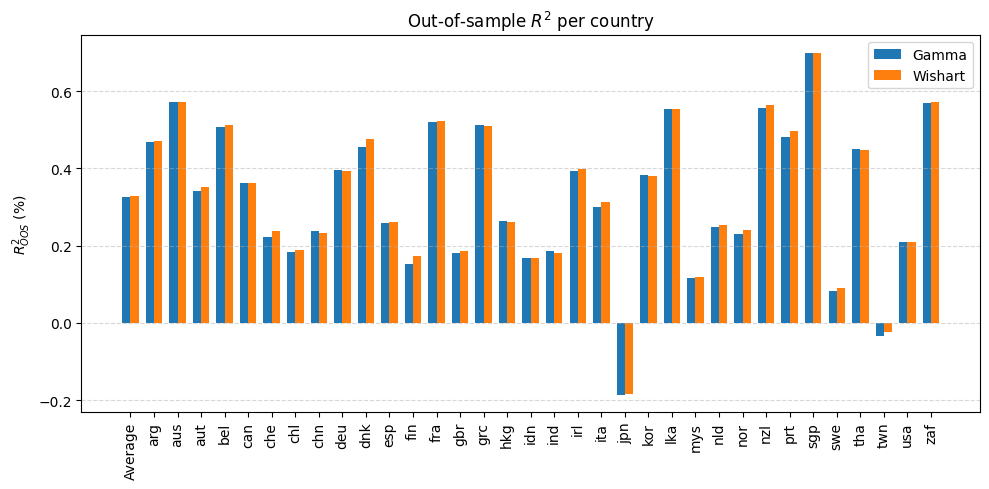

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
countries = list(r2_country_gamma.keys())
gamma_scores = list(r2_country_gamma.values())
wishart_scores = list(r2_country_wishart.values())

# Prepend average to the beginning of each list
gamma_scores = [np.mean(gamma_scores)] + gamma_scores
wishart_scores = [np.mean(wishart_scores)] + wishart_scores

labels = ["Average"] + countries

x = np.arange(len(labels))  # the label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, [r * 100 for r in gamma_scores], width, label='Gamma')
bars2 = ax.bar(x + width/2, [r * 100 for r in wishart_scores], width, label='Wishart')

# Labels and formatting
ax.set_ylabel('$R^2_{OOS}$ (%)')
ax.set_title('Out-of-sample $R^2$ per country')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90, ha='center')
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


## Portfolio construction and evaluation

In [14]:
preds_gamma = {}
preds_wishart = {}
preds_global = {}
for cntry in X_test:
    X = X_test[cntry]
    preds_gamma[cntry] = X @ (theta_g_gamma + theta_l_gamma[cntry])
    preds_wishart[cntry] = X @ (theta_g_wishart + theta_l_wishart[cntry])
    preds_global[cntry] = X @ global_coef

### Global portfolio

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm

def country_returns_and_weights_with_preds(cntry, preds, df_path, n_pfs=3):
    df = pd.read_parquet(f"{df_path}\\{cntry}.parquet")
    df_pf = df[["eom", "ret_exc_lead1m", "weight"]].copy()
    df_pf.loc[:,"preds"] = preds  

    # Quantile portfolios
    df_pf.loc[:, "pf"] = df_pf.groupby("eom")["preds"].transform(lambda x: pd.qcut(x, n_pfs, labels=[f"{i+1}" for i in range(n_pfs)]))

    # Value-weighted LS return
    pf_rets = df_pf.groupby(["eom", "pf"], observed=False)["ret_exc_lead1m"].agg(pf_ret = lambda x: np.average(x, weights=df_pf.loc[x.index, "weight"])).unstack()

    df_cntry = (pf_rets["pf_ret"][f"{n_pfs}"] - pf_rets["pf_ret"]["1"]).reset_index().rename({0: "ret"}, axis=1)
    df_cntry["weight"] = df_pf.groupby("eom")["weight"].sum().reset_index(drop=True)

    return df_cntry


local_pf_rets = pd.DataFrame({"eom": pd.unique(pd.read_parquet("D:/Bachelor Data/Test/irl.parquet", columns=["eom"])["eom"])})
gamma_pf_rets =  local_pf_rets.copy()
wishart_pf_rets =  local_pf_rets.copy()
global_pf_rets =  local_pf_rets.copy()
pf_weights = local_pf_rets.copy()

included_countries = list(X_test.keys())  
file_path = "D:/Bachelor Data/Test"
for cntry in tqdm(included_countries):
    # Gamma
    rw_gamma = country_returns_and_weights_with_preds(cntry, preds_gamma[cntry], file_path)
    gamma_pf_rets = gamma_pf_rets.merge(
        rw_gamma[["eom", "ret"]].rename(columns={"ret": cntry}), on="eom", how="left"
    )
    pf_weights = pf_weights.merge(rw_gamma[["eom", "weight"]].rename({"weight": cntry}, axis=1), on="eom", how="left")
    # Wishart
    rw_wishart = country_returns_and_weights_with_preds(cntry, preds_wishart[cntry], file_path)
    wishart_pf_rets = wishart_pf_rets.merge(
        rw_wishart[["eom", "ret"]].rename(columns={"ret": cntry}), on="eom", how="left"
    )
    rw_global = country_returns_and_weights_with_preds(cntry, preds_global[cntry], file_path)
    global_pf_rets = global_pf_rets.merge(
        rw_global[["eom", "ret"]].rename(columns={"ret": cntry}), on="eom", how="left"
    )

gamma_pf_rets.fillna(0.0, inplace=True)
wishart_pf_rets.fillna(0.0, inplace=True)
global_pf_rets.fillna(0.0, inplace=True)
pf_weights.fillna(0.0, inplace=True)

gamma_pf_rets = gamma_pf_rets.set_index("eom")
wishart_pf_rets = wishart_pf_rets.set_index("eom")
global_pf_rets = global_pf_rets.set_index("eom")
pf_weights = pf_weights.set_index("eom")

weights = pf_weights
# --- Gamma ---
rets_gamma = gamma_pf_rets
global_ls_ret_gamma = (rets_gamma * weights).sum(axis=1) / weights.sum(axis=1)


# --- Wishart ---
rets_wishart = wishart_pf_rets
global_ls_ret_wishart = (rets_wishart * weights).sum(axis=1) / weights.sum(axis=1)

# --- Global ---
rets_global = global_pf_rets
global_ls_ret_global = (rets_global * weights).sum(axis=1) / weights.sum(axis=1)


global_ls_ret_wishart = global_ls_ret_wishart.to_frame(name="ret").reset_index()
global_ls_ret_gamma = global_ls_ret_gamma.to_frame(name="ret").reset_index()
global_ls_ret_global = global_ls_ret_global.to_frame(name="ret").reset_index()

global_ls_ret_wishart["eom"] = pd.to_datetime(global_ls_ret_wishart["eom"], format="%Y%m%d")
global_ls_ret_gamma["eom"] = pd.to_datetime(global_ls_ret_gamma["eom"], format="%Y%m%d")
global_ls_ret_global["eom"] = pd.to_datetime(global_ls_ret_global["eom"], format="%Y%m%d")

global_ls_ret_gamma.index = global_ls_ret_gamma["eom"]
global_ls_ret_wishart.index = global_ls_ret_wishart["eom"]
global_ls_ret_global.index = global_ls_ret_global["eom"]

global_ls_ret_wishart = global_ls_ret_wishart.drop(columns=["eom"])
global_ls_ret_gamma = global_ls_ret_gamma.drop(columns=["eom"])
global_ls_ret_global = global_ls_ret_global.drop(columns=["eom"])


market_data = pd.read_csv("D:/Bachelor Data/market_returns.csv")


market_data["excntry"] = market_data["excntry"].str.lower()


market_data["eom"] = pd.to_datetime(market_data["eom"])



market_data_filtered = market_data[market_data["excntry"].isin(included_countries)]

country_caps = market_data_filtered.groupby(["eom", "excntry"])["me_lag1"].sum().rename("country_cap")


market_data_filtered = market_data_filtered.merge(country_caps, on=["eom", "excntry"], how="left")

weighted_market = (
    market_data_filtered.groupby("eom")
    .apply(lambda df: np.average(df["mkt_vw_exc"], weights=df["country_cap"]))
    .rename("global_mkt")
    .reset_index()
)

weighted_market = weighted_market.set_index("eom")


merged = pd.DataFrame({
    "global_ls_gamma": global_ls_ret_gamma["ret"],
    "global_ls_wishart": global_ls_ret_wishart["ret"],
    "global_ls_global": global_ls_ret_global["ret"],
    "global_mkt": weighted_market["global_mkt"]
}).dropna()



100%|██████████| 34/34 [01:07<00:00,  2.00s/it]
C:\Users\frede\AppData\Local\Temp\ipykernel_8640\1552670408.py:110: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: np.average(df["mkt_vw_exc"], weights=df["country_cap"]))


In [16]:
X_mkt = sm.add_constant(merged["global_mkt"], has_constant="add")
y = merged["global_ls_gamma"]
X_combo_global = sm.add_constant(merged[["global_mkt", "global_ls_global"]], has_constant="add")
model_gamma = sm.OLS(y, X_mkt).fit()
model_combo_gamma = sm.OLS(y, X_combo_global).fit()
y = merged["global_ls_wishart"]
model_wishart = sm.OLS(y, X_mkt).fit()
model_combo_wishart = sm.OLS(y, X_combo_global).fit()
X_combo_gamma_wishart = sm.add_constant(merged[["global_mkt", "global_ls_gamma"]], has_constant="add")
model_combo_gamma_wishart = sm.OLS(y, X_combo_gamma_wishart).fit()

In [17]:
print(model_gamma.summary())
print(model_wishart.summary())
print(model_combo_gamma.summary())
print(model_combo_wishart.summary())
print(model_combo_gamma_wishart.summary())

                            OLS Regression Results                            
Dep. Variable:        global_ls_gamma   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.08662
Date:                Thu, 22 May 2025   Prob (F-statistic):              0.769
Time:                        15:13:30   Log-Likelihood:                 629.22
No. Observations:                 264   AIC:                            -1254.
Df Residuals:                     262   BIC:                            -1247.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095      0.001      6.833      0.0

In [18]:
excess_ret_gamma = global_ls_ret_gamma["ret"].mean()
excess_ret_wishart = global_ls_ret_wishart["ret"].mean()

annual_ret_gamma = (1 + excess_ret_gamma) ** 12 - 1
annual_ret_wishart = (1 + excess_ret_wishart) ** 12 - 1

print(f"Annualized excess return (gamma): {annual_ret_gamma:.4%}")
print(f"Annualized excess return (wishart): {annual_ret_wishart:.4%}")


annual_alpha_gamma = (1 + model_gamma.params["const"]) ** 12 - 1
print(f"Annualized alpha_gamma: {annual_alpha_gamma:.4%}")

annual_alpha_wishart = (1 + model_wishart.params["const"]) ** 12 - 1
print(f"Annualized alpha_wishart: {annual_alpha_wishart:.4%}")

annual_alpha_combo = (1 + model_combo_gamma.params["const"]) ** 12 - 1
print(f"Annualized alpha_combo: {annual_alpha_combo:.4%}")

annual_alpha_combo_wishart = (1 + model_combo_wishart.params["const"]) ** 12 - 1
print(f"Annualized alpha_combo_wishart: {annual_alpha_combo_wishart:.4%}")


# --- Sharpe ratios (annualized) ---
mu_gamma = global_ls_ret_gamma["ret"].mean()
sigma_gamma = global_ls_ret_gamma["ret"].std()

mu_wishart = global_ls_ret_wishart["ret"].mean()
sigma_wishart = global_ls_ret_wishart["ret"].std()



sharpe_gamma = (mu_gamma / sigma_gamma) * np.sqrt(12)
sharpe_wishart = (mu_wishart / sigma_wishart) * np.sqrt(12)


print(f"Annualized Sharpe ratio (gamma): {sharpe_gamma:.3f}")
print(f"Annualized Sharpe ratio (wishart): {sharpe_wishart:.3f}")


# --- Information ratios (annualized alpha / tracking error) ---
resid_gamma = model_gamma.resid
resid_wishart = model_wishart.resid
resid_combo_gamma = model_combo_gamma.resid
resid_combo_wishart = model_combo_wishart.resid

tracking_error_gamma = resid_gamma.std() * np.sqrt(12)
tracking_error_wishart = resid_wishart.std() * np.sqrt(12)
tracking_error_combo_gamma = resid_combo_gamma.std() * np.sqrt(12)
tracking_error_combo_wishart = resid_combo_wishart.std() * np.sqrt(12)

info_ratio_gamma = annual_alpha_gamma / tracking_error_gamma
info_ratio_wishart = annual_alpha_wishart / tracking_error_wishart
info_ratio_combo_gamma = annual_alpha_combo / tracking_error_combo_gamma
info_ratio_combo_wishart = annual_alpha_combo_wishart / tracking_error_combo_wishart

print(f"Annualized Information ratio (gamma): {info_ratio_gamma:.3f}")
print(f"Annualized Information ratio (wishart): {info_ratio_wishart:.3f}")
print(f"Annualized Information ratio (combo gamma): {info_ratio_combo_gamma:.3f}")
print(f"Annualized Information ratio (combo wishart): {info_ratio_combo_wishart:.3f}")


Annualized excess return (gamma): 11.9247%
Annualized excess return (wishart): 11.8292%
Annualized alpha_gamma: 11.9827%
Annualized alpha_wishart: 11.9064%
Annualized alpha_combo: 1.5775%
Annualized alpha_combo_wishart: 1.4718%
Annualized Sharpe ratio (gamma): 1.461
Annualized Sharpe ratio (wishart): 1.447
Annualized Information ratio (gamma): 1.547
Annualized Information ratio (wishart): 1.534
Annualized Information ratio (combo gamma): 0.887
Annualized Information ratio (combo wishart): 0.853


### Global portfolio ex-us

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm

def country_returns_and_weights_with_preds(cntry, preds, df_path, n_pfs=3):
    df = pd.read_parquet(f"{df_path}\\{cntry}.parquet")
    df_pf = df[["eom", "ret_exc_lead1m", "weight"]].copy()
    df_pf.loc[:,"preds"] = preds  # already precomputed

    # Quantile portfolios
    df_pf.loc[:, "pf"] = df_pf.groupby("eom")["preds"].transform(lambda x: pd.qcut(x, n_pfs, labels=[f"{i+1}" for i in range(n_pfs)]))

    # Value-weighted LS return
    pf_rets = df_pf.groupby(["eom", "pf"], observed=False)["ret_exc_lead1m"].agg(pf_ret = lambda x: np.average(x, weights=df_pf.loc[x.index, "weight"])).unstack()

    df_cntry = (pf_rets["pf_ret"][f"{n_pfs}"] - pf_rets["pf_ret"]["1"]).reset_index().rename({0: "ret"}, axis=1)
    df_cntry["weight"] = df_pf.groupby("eom")["weight"].sum().reset_index(drop=True)

    return df_cntry

# Initialize result dataframes
local_pf_rets = pd.DataFrame({"eom": pd.unique(pd.read_parquet("D:/Bachelor Data/Test/irl.parquet", columns=["eom"])["eom"])})
gamma_pf_rets =  local_pf_rets.copy()
wishart_pf_rets =  local_pf_rets.copy()
global_pf_rets =  local_pf_rets.copy()
pf_weights = local_pf_rets.copy()
# Loop over countries
included_countries = [c for c in X_test if c != "usa"]
file_path = "D:/Bachelor Data/Test"
for cntry in tqdm(included_countries):
    # Gamma
    rw_gamma = country_returns_and_weights_with_preds(cntry, preds_gamma[cntry], file_path)
    gamma_pf_rets = gamma_pf_rets.merge(
        rw_gamma[["eom", "ret"]].rename(columns={"ret": cntry}), on="eom", how="left"
    )
    pf_weights = pf_weights.merge(rw_gamma[["eom", "weight"]].rename({"weight": cntry}, axis=1), on="eom", how="left")
    # Wishart
    rw_wishart = country_returns_and_weights_with_preds(cntry, preds_wishart[cntry], file_path)
    wishart_pf_rets = wishart_pf_rets.merge(
        rw_wishart[["eom", "ret"]].rename(columns={"ret": cntry}), on="eom", how="left"
    )
    rw_global = country_returns_and_weights_with_preds(cntry, preds_global[cntry], file_path)
    global_pf_rets = global_pf_rets.merge(
        rw_global[["eom", "ret"]].rename(columns={"ret": cntry}), on="eom", how="left"
    )

# Fill missing values
gamma_pf_rets.fillna(0.0, inplace=True)
wishart_pf_rets.fillna(0.0, inplace=True)
global_pf_rets.fillna(0.0, inplace=True)
pf_weights.fillna(0.0, inplace=True)

gamma_pf_rets = gamma_pf_rets.set_index("eom")
wishart_pf_rets = wishart_pf_rets.set_index("eom")
global_pf_rets = global_pf_rets.set_index("eom")
pf_weights = pf_weights.set_index("eom")

weights = pf_weights
# --- Gamma ---
rets_gamma = gamma_pf_rets
global_ls_ret_gamma = (rets_gamma * weights).sum(axis=1) / weights.sum(axis=1)


# --- Wishart ---
rets_wishart = wishart_pf_rets
global_ls_ret_wishart = (rets_wishart * weights).sum(axis=1) / weights.sum(axis=1)

# --- Global ---
rets_global = global_pf_rets
global_ls_ret_global = (rets_global * weights).sum(axis=1) / weights.sum(axis=1)


global_ls_ret_wishart = global_ls_ret_wishart.to_frame(name="ret").reset_index()
global_ls_ret_gamma = global_ls_ret_gamma.to_frame(name="ret").reset_index()
global_ls_ret_global = global_ls_ret_global.to_frame(name="ret").reset_index()

global_ls_ret_wishart["eom"] = pd.to_datetime(global_ls_ret_wishart["eom"], format="%Y%m%d")
global_ls_ret_gamma["eom"] = pd.to_datetime(global_ls_ret_gamma["eom"], format="%Y%m%d")
global_ls_ret_global["eom"] = pd.to_datetime(global_ls_ret_global["eom"], format="%Y%m%d")

global_ls_ret_gamma.index = global_ls_ret_gamma["eom"]
global_ls_ret_wishart.index = global_ls_ret_wishart["eom"]
global_ls_ret_global.index = global_ls_ret_global["eom"]

global_ls_ret_wishart = global_ls_ret_wishart.drop(columns=["eom"])
global_ls_ret_gamma = global_ls_ret_gamma.drop(columns=["eom"])
global_ls_ret_global = global_ls_ret_global.drop(columns=["eom"])


market_data = pd.read_csv("D:/Bachelor Data/market_returns.csv")


market_data["excntry"] = market_data["excntry"].str.lower()


market_data["eom"] = pd.to_datetime(market_data["eom"])

market_data_filtered = market_data[market_data["excntry"].isin(included_countries)]

country_caps = market_data_filtered.groupby(["eom", "excntry"])["me_lag1"].sum().rename("country_cap")


market_data_filtered = market_data_filtered.merge(country_caps, on=["eom", "excntry"], how="left")

weighted_market = (
    market_data_filtered.groupby("eom")
    .apply(lambda df: np.average(df["mkt_vw_exc"], weights=df["country_cap"]))
    .rename("global_mkt")
    .reset_index()
)

weighted_market = weighted_market.set_index("eom")


merged = pd.DataFrame({
    "global_ls_gamma": global_ls_ret_gamma["ret"],
    "global_ls_wishart": global_ls_ret_wishart["ret"],
    "global_ls_global": global_ls_ret_global["ret"],
    "global_mkt": weighted_market["global_mkt"]
}).dropna()



100%|██████████| 33/33 [01:13<00:00,  2.24s/it]
C:\Users\frede\AppData\Local\Temp\ipykernel_8640\2967054037.py:108: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: np.average(df["mkt_vw_exc"], weights=df["country_cap"]))


In [20]:
X_mkt = sm.add_constant(merged["global_mkt"], has_constant="add")
y = merged["global_ls_gamma"]
X_combo_global = sm.add_constant(merged[["global_mkt", "global_ls_global"]], has_constant="add")
model_gamma = sm.OLS(y, X_mkt).fit()
model_combo_gamma = sm.OLS(y, X_combo_global).fit()
y = merged["global_ls_wishart"]
model_wishart = sm.OLS(y, X_mkt).fit()
model_combo_wishart = sm.OLS(y, X_combo_global).fit()
X_combo_gamma_wishart = sm.add_constant(merged[["global_mkt", "global_ls_gamma"]], has_constant="add")
model_combo_gamma_wishart = sm.OLS(y, X_combo_gamma_wishart).fit()

In [21]:
print(model_gamma.summary())
print(model_wishart.summary())
print(model_combo_gamma.summary())
print(model_combo_wishart.summary())
print(model_combo_gamma_wishart.summary())

                            OLS Regression Results                            
Dep. Variable:        global_ls_gamma   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1626
Date:                Thu, 22 May 2025   Prob (F-statistic):              0.687
Time:                        15:16:15   Log-Likelihood:                 696.25
No. Observations:                 264   AIC:                            -1388.
Df Residuals:                     262   BIC:                            -1381.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0098      0.001      9.128      0.0

In [22]:
excess_ret_gamma = global_ls_ret_gamma["ret"].mean()
excess_ret_wishart = global_ls_ret_wishart["ret"].mean()

annual_ret_gamma = (1 + excess_ret_gamma) ** 12 - 1
annual_ret_wishart = (1 + excess_ret_wishart) ** 12 - 1

print(f"Annualized excess return (gamma): {annual_ret_gamma:.4%}")
print(f"Annualized excess return (wishart): {annual_ret_wishart:.4%}")


annual_alpha_gamma = (1 + model_gamma.params["const"]) ** 12 - 1
print(f"Annualized alpha_gamma: {annual_alpha_gamma:.4%}")

annual_alpha_wishart = (1 + model_wishart.params["const"]) ** 12 - 1
print(f"Annualized alpha_wishart: {annual_alpha_wishart:.4%}")

annual_alpha_combo = (1 + model_combo_gamma.params["const"]) ** 12 - 1
print(f"Annualized alpha_combo: {annual_alpha_combo:.4%}")

annual_alpha_combo_wishart = (1 + model_combo_wishart.params["const"]) ** 12 - 1
print(f"Annualized alpha_combo_wishart: {annual_alpha_combo_wishart:.4%}")


# --- Sharpe ratios (annualized) ---
mu_gamma = global_ls_ret_gamma["ret"].mean()
sigma_gamma = global_ls_ret_gamma["ret"].std()

mu_wishart = global_ls_ret_wishart["ret"].mean()
sigma_wishart = global_ls_ret_wishart["ret"].std()



sharpe_gamma = (mu_gamma / sigma_gamma) * np.sqrt(12)
sharpe_wishart = (mu_wishart / sigma_wishart) * np.sqrt(12)


print(f"Annualized Sharpe ratio (gamma): {sharpe_gamma:.3f}")
print(f"Annualized Sharpe ratio (wishart): {sharpe_wishart:.3f}")


# --- Information ratios (annualized alpha / tracking error) ---
resid_gamma = model_gamma.resid
resid_wishart = model_wishart.resid
resid_combo_gamma = model_combo_gamma.resid
resid_combo_wishart = model_combo_wishart.resid

tracking_error_gamma = resid_gamma.std() * np.sqrt(12)
tracking_error_wishart = resid_wishart.std() * np.sqrt(12)
tracking_error_combo_gamma = resid_combo_gamma.std() * np.sqrt(12)
tracking_error_combo_wishart = resid_combo_wishart.std() * np.sqrt(12)

info_ratio_gamma = annual_alpha_gamma / tracking_error_gamma
info_ratio_wishart = annual_alpha_wishart / tracking_error_wishart
info_ratio_combo_gamma = annual_alpha_combo / tracking_error_combo_gamma
info_ratio_combo_wishart = annual_alpha_combo_wishart / tracking_error_combo_wishart

print(f"Annualized Information ratio (gamma): {info_ratio_gamma:.3f}")
print(f"Annualized Information ratio (wishart): {info_ratio_wishart:.3f}")
print(f"Annualized Information ratio (combo gamma): {info_ratio_combo_gamma:.3f}")
print(f"Annualized Information ratio (combo wishart): {info_ratio_combo_wishart:.3f}")

Annualized excess return (gamma): 12.3669%
Annualized excess return (wishart): 12.2150%
Annualized alpha_gamma: 12.4185%
Annualized alpha_wishart: 12.2922%
Annualized alpha_combo: 2.7175%
Annualized alpha_combo_wishart: 2.5140%
Annualized Sharpe ratio (gamma): 1.949
Annualized Sharpe ratio (wishart): 1.922
Annualized Information ratio (gamma): 2.067
Annualized Information ratio (wishart): 2.041
Annualized Information ratio (combo gamma): 1.001
Annualized Information ratio (combo wishart): 0.952


# Posterior test evaluation

In [43]:
import importlib
import post_analyzer
importlib.reload(post_analyzer)
from post_analyzer import PosteriorAnalyzer


theta_g_path = r'D:\Bachelor\theta_g_samples_test_optimal.parquet'
theta_l_path = r'D:\Bachelor\theta_l_samples_test_optimal.parquet'
gc_path = r'D:\Bachelor\Gc_samples_test_optimal.parquet'
sigma2_path = r'D:\Bachelor\sigma2_test_optimal.parquet'



post_analyzer_test = PosteriorAnalyzer(
    theta_g_path=theta_g_path,
    theta_l_path=theta_l_path,
    gc_path=gc_path,
    sigma2_path=sigma2_path,
    burn_in=0
)

theta_g_samples = post_analyzer_test.get_theta_g_samples()
theta_l_samples = post_analyzer_test.get_theta_l_samples("jpn")

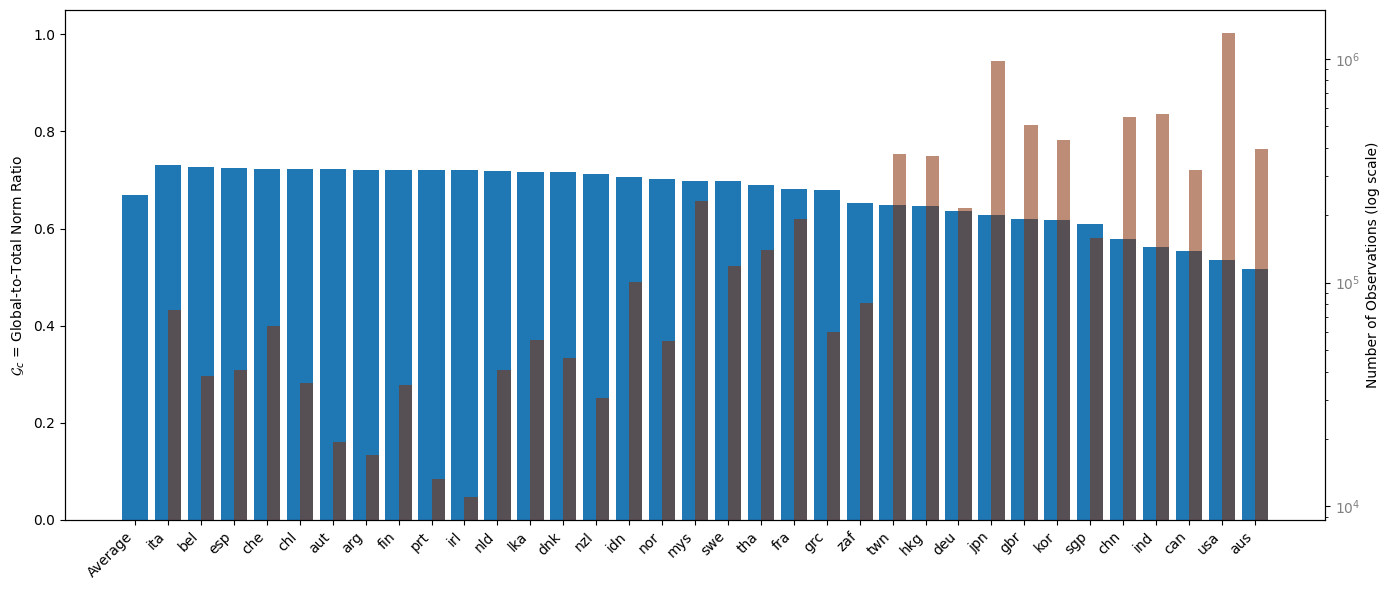

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



Gc_mean = post_analyzer_test.get_Gc_posterior_mean()
Gc_mean["Average"] = np.mean([v for k, v in Gc_mean.items() if k != "Average"])

obs_counts = {k: X_test[k].shape[0] for k in Gc_mean if k != "Average"}
obs_counts["Average"] = np.nan  

sorted_keys = ["Average"] + sorted([k for k in Gc_mean if k != "Average"], key=lambda x: Gc_mean[x], reverse=True)
Gc_mean_ordered = pd.Series({k: Gc_mean[k] for k in sorted_keys})
obs_counts_ordered = pd.Series({k: obs_counts[k] for k in sorted_keys})

fig, ax1 = plt.subplots(figsize=(14, 6))
plt.style.use('default')
bars1 = ax1.bar(Gc_mean_ordered.index, Gc_mean_ordered.values)
ax1.set_ylabel("$\\mathcal{G}_c$ = Global-to-Total Norm Ratio")
ax1.set_ylim(0, 1.05)
ax1.tick_params(axis='y')
ax1.set_xticks(np.arange(len(Gc_mean_ordered)))
ax1.set_xticklabels(Gc_mean_ordered.index, rotation=45, ha='right')


bar2_color = "#852E06"
ax2 = ax1.twinx()
bars2 = ax2.bar(Gc_mean_ordered.index, obs_counts_ordered.values, 
                alpha=0.55, width=0.4, align='edge', color=bar2_color, label="Obs. Count")
ax2.set_ylabel("Number of Observations (log scale)")
ax2.tick_params(axis='y', labelcolor="gray")
ax2.set_yscale("log")
ax2.set_zorder(0)

plt.grid(False)
plt.tight_layout()
plt.show()


d:\Bachelor\src\post_analyzer.py:238: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{y:.3f}" for y in yticks])


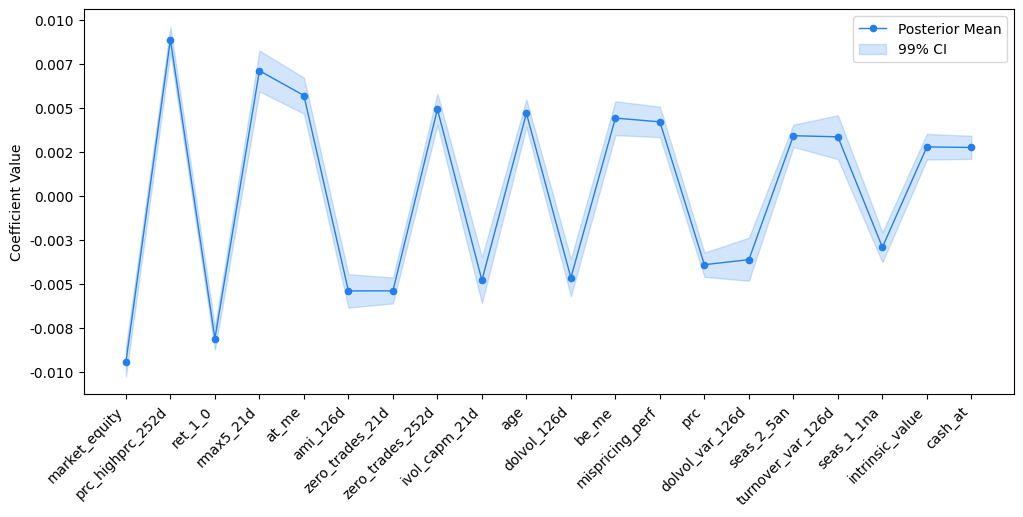

In [49]:
post_analyzer_test.plot_top_features_with_ci("theta_g",top_n=20,ci = 0.99)

d:\Bachelor\src\post_analyzer.py:248: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{y:.3f}" for y in yticks])


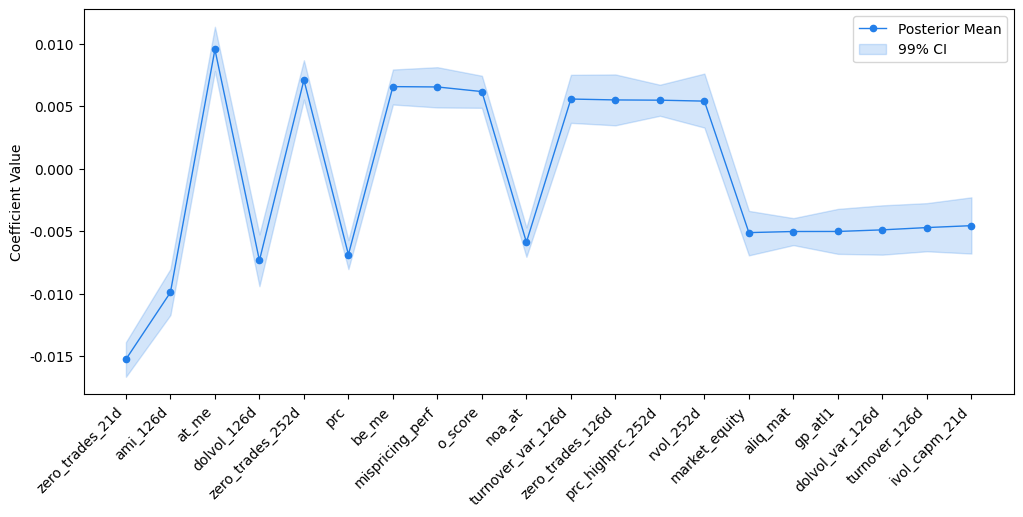

In [50]:
post_analyzer_test.plot_top_features_with_ci("theta_c","usa",top_n=20, ci=0.99)

d:\Bachelor\src\post_analyzer.py:248: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{y:.3f}" for y in yticks])


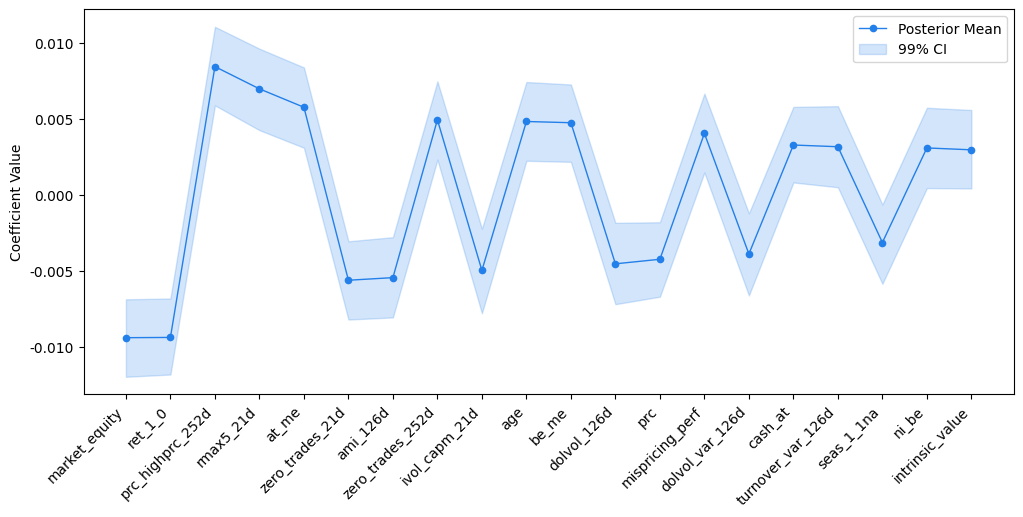

In [51]:
post_analyzer_test.plot_top_features_with_ci("theta_c","irl",top_n=20, ci=0.99)

# Data evaluation

In [33]:
del X_dict_train, Y_dict_train, X_dict_test, Y_dict_test

In [ ]:
import numpy as np
import pandas as pd
from data_loader import CountryDataLoader

file_path = r'D:\Bachelor Data\Train'

loader = CountryDataLoader(
    data_path=file_path,
    standardize=False,
    countries=None,  
    mode="train"
)
features_to_drop = ["eom", "gvkey", "y", "weight","ret_exc_lead1m"]

loader.load_data()
train_data = loader.data_dict

# --- Train data ---
X_dict_train = {
    c: df.drop(columns=features_to_drop).to_numpy()
    for c, df in train_data.items()
}

Y_dict_train = {
    c: df["y"].to_numpy()
    for c, df in train_data.items()
}

file_path = r'D:\Bachelor Data\Test'

loader_test = CountryDataLoader(
    data_path=file_path,
    standardize=False,
    countries=None, 
    mode="test"
)
features_to_drop = ["eom", "gvkey", "y", "weight","ret_exc_lead1m"]

loader_test.load_data()
test_data = loader_test.data_dict

# --- Train data ---
X_dict_test= {
    c: df.drop(columns=features_to_drop).to_numpy()
    for c, df in test_data.items()
}

Y_dict_test = {
    c: df["y"].to_numpy()
    for c, df in test_data.items()
}



In [ ]:
import pandas as pd
import plotly.express as px

def plot_plotly_country_heatmap(data_dict, title):
    data = pd.DataFrame({
        "Country": [c.upper() for c in data_dict.keys()],
        "Observations": [len(df) for df in data_dict.values()]
    })

    fig = px.treemap(
        data,
        path=["Country"],
        values="Observations",
        color="Observations",
        color_continuous_scale="Greens",
        title=title
    )
    fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25),
    height=700,  
    width=600,   
    ) 
    fig.update_traces(
    texttemplate="%{label}<br>%{value:,}",  
    textfont_size=14
    )
    fig.show()

plot_plotly_country_heatmap(X_dict_train, title="1926-1999 Observation Heatmap")
plot_plotly_country_heatmap(X_dict_test, title="2000-2021 Observation Heatmap")
